In [1]:
# Load Events
from coffea.nanoevents import NanoEventsFactory, FCC, BaseSchema

events = NanoEventsFactory.from_root(
    "../../../../data/eos/experiment/fcc/ee/generation/DelphesEvents/winter2023/IDEA/p8_ee_ZZ_ecm240/events_136205668.root:events",
    schemaclass=FCC.get_schema("pre-edm4hep1"),
    # schemaclass=BaseSchema,
    # entry_stop=10000,
    delayed=True,
    uproot_options = {"filter_name": lambda x : "PARAMETERS" not in x}
).events()

/home/prayag/coffeafcc/development/coffea/src/coffea/nanoevents/schemas/edm4hep.py:7: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:224: UserWarning: Skipping _intMap as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:232: UserWarning: Skipping _intMap.first as it is not interpretable by Uproot
  warnings.

In [60]:
# Helper functions: functions.py
import awkward as ak
import numpy as np
import vector
vector.register_awkward()
# 1. To replace: FCCAnalyses::ZHfunctions::resonanceBuilder_mass(91.2,false)(selected_muons, MCRecoAssociations0, MCRecoAssociations1, ReconstructedParticles, Particle, Particle0, Particle1)
def resonanceBuilder_mass(resonance_mass=None, use_MC_Kinematics=False, leptons=None, MCRecoAssociations=None, ReconstructedParticles=None, MCParticles=None):
    '''
    Build the Z resonance based on the available leptons. Returns the best lepton pair compatible with the Z mass and recoil at 125 GeV
    technically, it returns a ReconstructedParticleData object with index 0 the di-lepton system, index and 2 the leptons of the pair
    '''
    if leptons is None:
        raise AttributeError("No leptons passed")
    #Create all the combinations
    combs = ak.combinations(leptons,2)
    # Get dileptons
    lep1 , lep2 = ak.unzip(combs)
    di_lep = lep1 + lep2 # This process drops any other field except 4 momentum fields

    di_lep["charge"] =  lep1.charge + lep2.charge
    di_lep["l1_index"] = lep1.index
    di_lep["l2_index"] = lep2.index

    # Choose oppositely charged leptons
    di_lep = di_lep[di_lep.charge == 0]

    # Sort by closest mass to the resonance value
    sort_mask = ak.argsort(abs(resonance_mass-di_lep.mass), axis=1)
    Reso = di_lep[sort_mask]

    return Reso
    return Reso, used_lep1, used_lep2

# 2. To replace: FCCAnalyses::ZHfunctions::getTwoHighestPMuons(rest_of_muons)") # Find the higest p muon pair from the remaining muons (off-shell Z)
def getTwoHighestPMuons(muons):
    '''
    Sort by decending P and return the pair of particles with highest P and opposite charges
    '''
    # if not ak.all(ak.num(muons, axis=1) > 1 ):
    #     raise IndexError("Need at least two particles!")
    sorted_muons_p = ak.argsort(muons.p, ascending=False)
    sorted_muons = muons[sorted_muons_p]

    # First particle is always selected, if the second one has the opposite charge, then its accepted otherwise we move on to the third and so on
    # Interestingly, this type of operation is non trivial in an array format
    first_muon, other_muons = sorted_muons[:, 0:1], sorted_muons[:, 1:]

    # prepare before cartesian : replace none with []
    first_muon = ak.fill_none(first_muon, [], axis=0)
    other_muons = ak.fill_none(other_muons, [], axis=0)
    # All combinations
    all_comb = ak.cartesian([first_muon, other_muons])
    l1, l2 = ak.unzip(all_comb)
    charge_mask = l1.charge!= l2.charge
    # charge_mask = abs(l1.charge) >= 0
    l1 = l1[charge_mask]
    l2 = l2[charge_mask]

    at_least_one_opp_charged = ak.sum(charge_mask, axis=1) > 0
    
    return ak.firsts(ak.mask(l1,at_least_one_opp_charged)), ak.firsts(ak.mask(l2,at_least_one_opp_charged)), at_least_one_opp_charged
# 3. To sum all the lorentz vectors in a an array of lorentzvectors
def sum_all(array_of_lv):
    #array_of_lv = ak.drop_none(array_of_lv)

    out = ak.zip(
        {
            "px":ak.sum(array_of_lv.px , axis=1),
            "py":ak.sum(array_of_lv.py , axis=1),
            "pz":ak.sum(array_of_lv.pz , axis=1),
            "E":ak.sum(array_of_lv.E , axis=1)
        },
        with_name="Momemtum4D"
    )

    return out
# 4. To replace : FCCAnalyses::ZHfunctions::coneIsolation(0.0,0.523599)(fourMuons,rest_of_particles)
def coneIsolation(particle, rest_of_the_particles, min_dr=0.0 , max_dr=0.4):
    ''' Refer: https://github.com/delphes/delphes/blob/master/modules/Isolation.cc#L154
    '''
    neutral_particles = ak.mask(rest_of_the_particles, rest_of_the_particles.charge == 0)
    charged_particles = ak.mask(rest_of_the_particles, rest_of_the_particles.charge != 0)

    n_combs = ak.cartesian((particle,neutral_particles[:,np.newaxis]), axis=1)
    n1,n2 = ak.unzip(n_combs)
    c_combs = ak.cartesian((particle,charged_particles[:,np.newaxis]), axis=1)
    c1,c2 = ak.unzip(c_combs)

    n_angle = n1.deltaangle(n2)
    c_angle = c1.deltaangle(c2)

    n_angle_mask = (n_angle < max_dr) & (n_angle >= min_dr)
    c_angle_mask = (c_angle < max_dr) & (c_angle >= min_dr)

    filtered_neutral = n2[n_angle_mask]
    filtered_charged = c2[c_angle_mask]

    sumNeutral = ak.sum(filtered_neutral.p, axis=2)
    sumCharged = ak.sum(filtered_charged.p, axis=2)

    total_sum = sumNeutral + sumCharged

    ratio = total_sum / particle.p

    return ratio


In [61]:
# Helper functions: Reconstructedparticles.py
import dask_awkward as dak
import awkward as ak
import numpy as np


def resonanceBuilder(lepton, resonance):
    '''
    Builds Resonance candidates
    Input:    lepton(var*[var*LorentzVector]),
              resonance(float)
    Output: Reso([var*LorentzVecctor]) best resonance candidate in each event (maximum one per event)
    '''
    #Create all the combinations
    combs = ak.combinations(lepton,2)
    # Get dileptons
    lep1 , lep2 = ak.unzip(combs)
    di_lep = lep1 + lep2 # This process drops any other field except 4 momentum fields

    di_lep = ak.zip({"px":di_lep.px,"py":di_lep.py,"pz":di_lep.pz,"E":di_lep.E,"charge":lep1.charge + lep2.charge}, with_name="Momentum4D")

    # Sort by closest mass to the resonance value
    sort_mask = ak.argsort(abs(resonance-di_lep.mass), axis=1)
    Reso = di_lep[sort_mask]

    #Choose the best candidate
    Reso = ak.fill_none(Reso,[],axis=0) #Transform the None values at axis 0 to [], so that they survive the next operation
    Reso = ak.firsts(Reso) #Chooses the first elements and flattens out, [] gets converted to None

    return Reso

def recoilBuilder(vec, ecm):
    '''
    Builds Recoil from a given LorentzVector and Center of Mass Energy
    Input:    vec(var*[var*LorentzVector]),
              ecm(float)
    Output: Recoil([var*LorentzVecctor])
    '''
    Recoil = ak.zip({"px":0.0-vec.px,"py":0.0-vec.py,"pz":0.0-vec.pz,"E":ecm-vec.E},with_name="Momentum4D")
    return Recoil


def remove(array, idx):
    '''
    Returns all the particles except the indices defined in idx.index.
    Eg. remove(events.ReconstructedParticle, events.Muonidx0) returns the events.ReconstructedParticle array with all the muons removed
    '''
    index = idx.index
    all_index = ak.local_index(array,axis=1)

    i,a = ak.unzip(ak.cartesian([index[:,np.newaxis] ,all_index], nested=True))
    c = a == i
    d = ak.firsts(c)
    s = ak.sum(d, axis=2)
    kl = s == 1
    
    return array[~kl]


In [62]:
import hist.dask as hda
import hist

def get_1Dhist(name, var, flatten=False):
    '''
    name: eg. Zm
    var: eg. variable containing array of mass of Z
    flatten: If to flatten var before fill; True by default
    Returns a histogram
    '''
    props = plot_props[name]
    if flatten : var = dak.ravel(var) # Removes None values and all the nesting
    var = var[~dak.is_none(var, axis=0)] # Remove None values only
    return hda.Hist.new.Reg(props.bins, props.xmin, props.xmax).Double().fill(var)

def create_mask(a, b, c):
    mask1 = a != c
    mask2 = b != c
    mask = mask1 & mask2
    return mask

In [63]:
# Main calculations
Muons = events.ReconstructedParticles[events.Muonidx0.index]
Muons["index"] = events.Muonidx0.index # Attach the local index for easier calculations later
sel_muon = Muons.p > 2.0
selected_muons_with_p_gt_2 = ak.mask(Muons, sel_muon)

# Select events with at least 4 muons
at_least_4_muons = ak.num(ak.drop_none(selected_muons_with_p_gt_2), axis=1) > 3
selected_muons = ak.mask(selected_muons_with_p_gt_2, at_least_4_muons)

# Build Z resonances
Z = resonanceBuilder_mass(resonance_mass=91.2, use_MC_Kinematics=False, leptons=selected_muons)

# On Shell Z
zll = ak.firsts(Z) # 100000 - 232
l1 = ak.firsts(selected_muons[selected_muons.index == zll.l1_index])
l2 = ak.firsts(selected_muons[selected_muons.index == zll.l2_index])

# Remove the used up muons from the muon list
mask = create_mask(zll.l1_index, zll.l2_index, selected_muons.index)
rest_of_muons = selected_muons[mask]

m1, m2, c_mask = getTwoHighestPMuons(rest_of_muons)

non_res_Z = m1 + m2 # 100000 - 213
# Angle between the two
non_res_Z_angle = m1.deltaangle(m2)

# Collect all the four Muons
fourMuons_collected = ak.concatenate(
    (
        ak.mask(l1,c_mask)[:, np.newaxis],
        ak.mask(l2,c_mask)[:, np.newaxis],
        m1[:, np.newaxis],
        m2[:, np.newaxis]
    ),
    axis=1
)
fourMuons_collected = ak.mask(fourMuons_collected, ak.num(fourMuons_collected, axis=1) > 3)
fourMuons = ak.mask(zll, c_mask) + non_res_Z

fourMuons_pmin = ak.min(fourMuons_collected.p, axis=1)
#print('fourMuons_pmin: ', fourMuons_pmin.head())

chosen_reco_4_mu = ak.mask(events.ReconstructedParticles, at_least_4_muons)
chosen_reco = ak.mask(chosen_reco_4_mu,c_mask)
#print('chosen_reco: ', chosen_reco.head() )

rest_of_particles = remove(chosen_reco, fourMuons_collected)
all_others = sum_all(rest_of_particles)
#print('all_others: ', all_others.head())

Emiss = recoilBuilder(sum_all(chosen_reco), ecm=240)
pmiss = Emiss.E
#print('pmiss: ', pmiss.head())

# Cone Isolation
fourMuons_iso = coneIsolation(fourMuons_collected, rest_of_particles, min_dr=0.0, max_dr=0.523599)
#print('fourMuons_iso: ', fourMuons_iso.head())
fourMuons_min_iso = ak.max(fourMuons_iso, axis=1)
#print('fourMuons_min_iso: ', fourMuons_min_iso.head())


In [74]:
vis_e = ak.drop_none(all_others.E).compute()
vis_e

<Array [0, 31.5, 0.0904, 140, ..., 2.39, 4.51, 4.15] type='213 * float32'>

In [65]:
import hist
cross_section = 1.35899
int_lumi = 10.80e+06
total_events = 100000

scale = cross_section*int_lumi/total_events

res_Z_hist = hda.Hist.new.Regular(50,0,250).Double().fill(ak.drop_none(zll.m))*scale
non_res_Z_hist = hda.Hist.new.Regular(50,0,250).Double().fill(ak.drop_none(non_res_Z.m))*scale
four_muon_mass_hist = hda.Hist.new.Regular(50,0,250).Double().fill(ak.drop_none(fourMuons.m))*scale
iso_hist = hist.Hist.new.Regular(50,0,20).Double().fill(ak.drop_none(fourMuons_min_iso).compute())*scale
vis_e_hist = hist.Hist.new.Regular(50,0,20).Double().fill(ak.drop_none(fourMuons_min_iso).compute())*scale

In [66]:
scale

146.77092

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f4789c65130>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

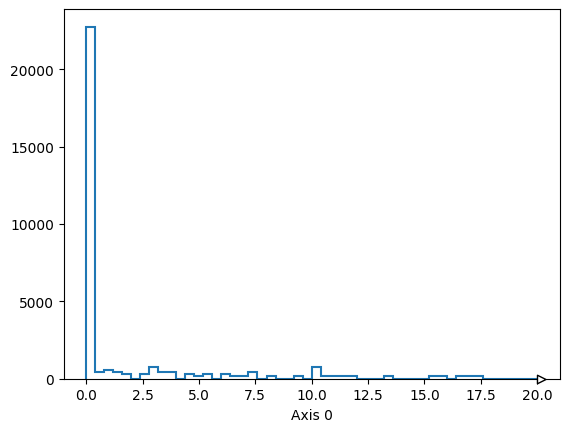

In [67]:
(iso_hist).plot(yerr=0)

In [68]:
ak.drop_none(non_res_Z.m).compute()

<Array [18.9, 28.8, 68.4, ..., 146, 92.1, 9.81] type='213 * float32[paramet...'>

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f479e01fcb0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

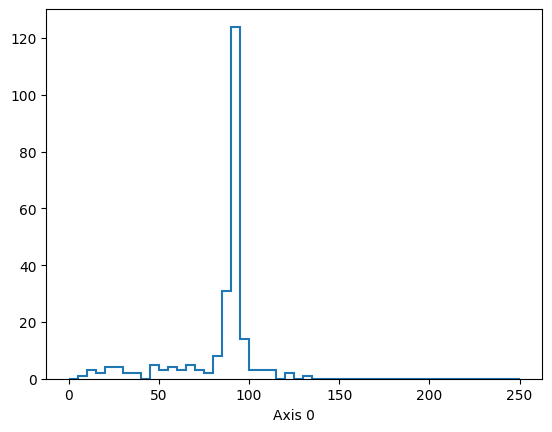

In [69]:
res_Z_hist.compute().plot(yerr=0)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f47bcb1c4a0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

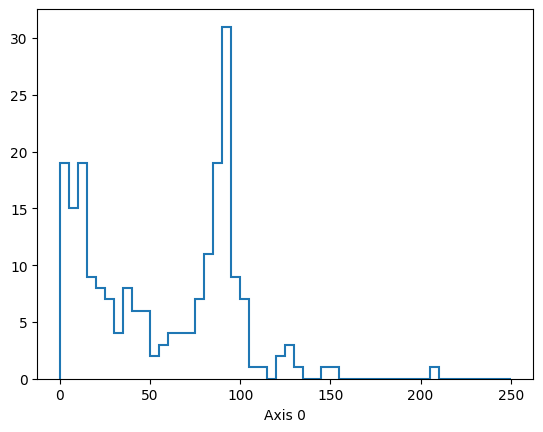

In [70]:
non_res_Z_hist.compute().plot(yerr=0)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f47bcb50aa0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

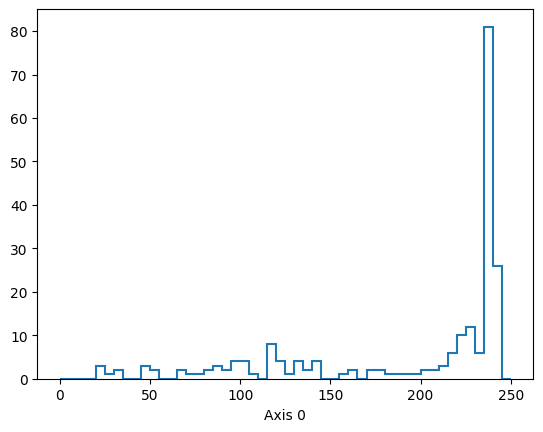

In [71]:
four_muon_mass_hist.compute().plot(yerr=0)

In [12]:
import uproot
f = uproot.open("with_filter/p8_ee_ZZ_ecm240.root")
their_output = f['events'].arrays()

In [13]:
their_output.fields

['selected_muons_n',
 'selected_muons_p',
 'rest_of_muons.type',
 'rest_of_muons.energy',
 'rest_of_muons.momentum.x',
 'rest_of_muons.momentum.y',
 'rest_of_muons.momentum.z',
 'rest_of_muons.referencePoint.x',
 'rest_of_muons.referencePoint.y',
 'rest_of_muons.referencePoint.z',
 'rest_of_muons.charge',
 'rest_of_muons.mass',
 'rest_of_muons.goodnessOfPID',
 'rest_of_muons.covMatrix[10]',
 'rest_of_muons.clusters_begin',
 'rest_of_muons.clusters_end',
 'rest_of_muons.tracks_begin',
 'rest_of_muons.tracks_end',
 'rest_of_muons.particles_begin',
 'rest_of_muons.particles_end',
 'rest_of_muons.particleIDs_begin',
 'rest_of_muons.particleIDs_end',
 'fourMuons_p',
 'fourMuons_mass',
 'zll_mass',
 'non_res_Z.type',
 'non_res_Z.energy',
 'non_res_Z.momentum.x',
 'non_res_Z.momentum.y',
 'non_res_Z.momentum.z',
 'non_res_Z.referencePoint.x',
 'non_res_Z.referencePoint.y',
 'non_res_Z.referencePoint.z',
 'non_res_Z.charge',
 'non_res_Z.mass',
 'non_res_Z.goodnessOfPID',
 'non_res_Z.covMatrix[

In [14]:
# Im guessing due to multithread processing in FCCAnalyses, the order of events processed is not conserved ... we need to sort and check
def sort_all(array):
    '''sort by axis 0 and 1'''
    sort_0 = ak.sort(array, axis=0)
    if array.layout.branch_depth[1] > 1:
        sort_0and1 = ak.sort(sort_0, axis=1)
    else:
        sort_0and1 = sort_0
    return sort_0and1
    
def compare(our_arr_raw, their_arr_raw, tolerance=0):
    our_arr = sort_all(our_arr_raw)
    their_arr = sort_all(their_arr_raw) 
    try:
        assert ak.all(abs(our_arr - their_arr) < tolerance)
        print('Our and their results match\n')
    except:
        print("Our and their results don't match\n")
        print("\tChecking for shapes ...\n")
        our_axis_0 = ak.num(our_arr, axis=0)
        their_axis_0 = ak.num(their_arr, axis=0)
        if our_axis_0 == their_axis_0:
            print("\tTotal number of events (axis 0 shapes) are the same : ", their_axis_0)
            if their_arr.layout.branch_depth[1] == 1:
                print("\tThese are flat arrays ...")
                print("\tChecking where the values do not match ...")
                for i in range(their_axis_0):
                    if abs(our_arr[i] - their_arr[i]) < tolerance:
                        print(f"\tFound mismatch in index: {i}")
                        print(f"\t\tOur index {i} is: {our_arr[i]}")
                        print(f"\t\tTheir index {i} is: {their_arr[i]}")
                return 0
            our_axis_1 = ak.num(our_arr, axis=1)
            their_axis_1 = ak.num(their_arr, axis=1)
            comparison = our_axis_1 == their_axis_1
            if ak.all(comparison):
                print("\tThe axis 1 shapes are the same")
                print("\tChecking where the values do not match ...")
            else:
                print("\tThe axis 1 shapes are not the same")
                print("\tFinding out where the mismatch lies ...\n")
                for i in range(their_axis_0):
                    if not comparison[i]:
                        print(f"\tFound mismatch in index: {i}")
                        print(f"\t\tOur index {i} is: {our_arr[i]}")
                        print(f"\t\tTheir index {i} is: {their_arr[i]}")
        else:
            print("\tTotal number of events (axis 0 shapes) are not the same : ours ",our_axis_0, " vs theirs ", their_axis_0)
            return 0

In [77]:
diff = abs(vis_e - their_output['vis_e_other_particles'])
diff

<Array [0, 8.16e-07, 1.95e-10, ..., 1.14e-07, 6.77e-08] type='213 * float64'>

In [79]:
diff[diff > 0.5]

<Array [0.615, 0.997, 0.529, ..., 0.52, 0.577, 0.938] type='13 * float64'>

In [55]:
a = ak.drop_none(fourMuons_iso).compute()

In [57]:
o = a[ak.num(a, axis=1) > 0]
o

<Array [[0, 0, 0, 0], ..., [0, 0, ..., 0.146]] type='213 * var * float32'>

In [58]:
compare(o, their_output['fourMuons_iso'])

Our and their results don't match

	Checking for shapes ...

	Total number of events (axis 0 shapes) are the same :  213
	The axis 1 shapes are the same
	Checking where the values do not match ...


In [59]:
abs(o-their_output['fourMuons_iso'])

<Array [[0, 0, 0, 0], ..., [0, 0, ..., 1.49e-08]] type='213 * var * float32'>